In [ ]:
using PyPlot

# Your code for ksintegrateNaive function goes here...
function ksintegrateNaive(u, Lx, dt, Nt, nplot);
    Nx = length(u)                  # number of gridpoints
    kx = vcat(0:Nx/2-1, 0, -Nx/2+1:-1)  # integer wavenumbers: exp(2*pi*i*kx*x/L)
    alpha = 2*pi*kx/Lx              # real wavenumbers:    exp(i*alpha*x)
    D = 1im*alpha                   # D = d/dx operator in Fourier space
    L = alpha.^2 - alpha.^4         # linear operator -D^2 - D^4 in Fourier space
    G = -0.5*D                      # -1/2 D operator in Fourier space
    Nplot = round(Int64, Nt/nplot)+1  # total number of saved time steps
    
    x = collect(0:Nx-1)*Lx/Nx
    t = collect(0:Nplot)*dt*nplot
    U = zeros(Nplot, Nx)
    
    # some convenience variables
    dt2  = dt/2
    dt32 = 3*dt/2
    A =  ones(Nx) + dt2*L
    B = (ones(Nx) - dt2*L).^(-1)

    Nn  = G.*fft(u.*u); # -1/2 d/dx(u^2) = -u u_x, collocation calculation
    Nn1 = Nn;

    U[1,:] = u; # save initial value u to matrix U
    np = 2;     # counter for saved data
    
    # transform data to spectral coeffs 
    u  = fft(u);

    # timestepping loop
    for n = 0:Nt-1
        Nn1 = Nn;                       # shift N^{n-1} <- N^n
        Nn  = G.*fft(real(ifft(u)).^2); # compute N^n = -u u_x

        u = B .* (A .* u + dt32*Nn - dt2*Nn1); # CNAB2 formula
        
        if mod(n, nplot) == 0
            U[np,:] = real(ifft(u))
            np += 1            
        end
    end  
    U,x,t
end






# Run the Julia code and plot results
Lx = 128
Nx = 1024
dt = 1/16
nplot = 8
Nt = 1600

x = Lx * (0:Nx-1) / Nx
u = cos.(x) + 0.1 * cos.(x/16) .* (1 + 2 * sin.(x/16))

U, x, t = ksintegrateNaive(u, Lx, dt, Nt, nplot)

imshow(U, aspect="auto", origin="lower", extent=[x[1], x[end], t[1], t[end]])
colorbar()
xlim(x[1], x[end])
ylim(t[1], t[end])
xlabel("x")
ylabel("t")
title("Kuramoto-Sivashinsky dynamics")

show()


In [ ]:
julia> using FFTW

julia> using PyPlot

julia> U, x, t = ksintegrateNaive(u, Lx, dt, Nt, nplot)
([1.1 1.0937570519095268 … -0.5317542786163998 -0.6386616001502329; -0.32086180759048444 -0.07468706056602109 … 0.8554714713940871 1.1701250204108686; … ; -0.38913724160160124 -0.17644107561189007 … -0.33882421172324706 -0.012980226106038995; 0.0617068039561402 0.23236378977709035 … 0.17509561408486995 0.47190156021261037], [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  126.75, 126.875, 127.0, 127.125, 127.25, 127.375, 127.5, 127.625, 127.75, 127.875], [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  96.0, 96.5, 97.0, 97.5, 98.0, 98.5, 99.0, 99.5, 100.0, 100.5])

In [ ]:
using PyPlot

# Create a 10x10 plot grid with higher dpi
fig, axs = subplots(10, 10, figsize=(10, 10), dpi=200)

# Rest of the plotting code...


In [ ]:


# Specify the desired time t
t = i

# Find the index of the closest time value in the t array
t_index = argmin(abs.(t .- t))

# Extract the corresponding row from the U matrix
slice = U[t_index, :]

# Create the plot
plot(x, slice)

# Set labels and title for the plot
xlabel("x")
ylabel("u")
title("Slice of Heatmap at Time t")

# Show the plot
show()


In [2]:
# Step 1: Install Necessary Functions 
%pip install Pillow
%pip install opencv-python
%pip install scipy
%pip install ripser
%pip install plotly





Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
from PIL import Image
import cv2
import glob
from scipy.interpolate import interp2d
#warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
from scipy.interpolate import CubicSpline
from ripser import ripser 
from persim import plot_diagrams
from time import time

from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import os
from pathlib import Path

from scipy import interpolate

In [12]:
# Auxiliary video functions
def getSlidingWindowVideo(I, dim, Tau, dT):
    N = I.shape[0] #Number of frames
    P = I.shape[1] #Number of pixels (possibly after PCA)
    pix = np.arange(P)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    X = np.zeros((NWindows, dim*P))
    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))
        f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
        X[i, :] = f(pix, idxx).flatten()
    return X

def writeVideo(filename, frame_data, fps, resol ):
    n_row, n_col = resol
    out = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (n_col, n_row))
    if frame_data.dtype !='uint8':
        frame_data -= np.amin(frame_data)
        frame_data *= 255/np.amax(frame_data)
        frame_data = np.uint8(frame_data)
    for frame in frame_data:
        out.write(frame.reshape((n_row, n_col,-1)))
    out.release()

def playVideo(filepath):
    cap = cv2.VideoCapture(filepath)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('frame', frame)
        if cv2.waitKey(24) == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()  

def loadVideo(filepath):
    vid = cv2.VideoCapture(filepath)
    _, image = vid.read()
    count = 0
    success = True
    n_row, n_col, _ = image.shape
    data = []
    while success:
        data.append(image.flatten()) 
        success,image = vid.read()
        count += 1
    vid.release() 
    data = np.array(data)
    print(count, " frames extracted")
    print("frame size = ", (n_row , n_col))
    print("data shape =", data.shape)
    return data , (n_row, n_col)

In [13]:
def loadFrame(framefilepath): 
    image_path = framefilepath
    image = cv2.imread(image_path)
    
    # Split the image into RGB channels
    blue_channel, green_channel, red_channel = cv2.split(image)

    pixels = image.reshape(-1, 3)
    
    return pixels 

In [14]:
import os
import glob

# Specify the path to the input folder
folder_path = "/Users/meddy/Documents/juPyter notebooks/Frames (Kuramoto Sivashinsky)"
# Get a list of file names in the folder
file_names = glob.glob(os.path.join(folder_path, "*.png"))

# Define the custom sorting key function
def get_file_number(file_path):
    # Extract the number from the file name
    try:
        file_name = os.path.basename(file_path)  # Extract the file name from the full path
        number = int(file_name.split('.')[0].replace('slice_', ''))  # Assuming the number is before the file extension
    except ValueError:
        number = float('inf')  # Assign a high value if the file name doesn't contain a number
    return number

# Sort the file names based on the custom sorting key
sorted_file_names = sorted(file_names, key=get_file_number)

In [15]:
filepath_list=[]
# Iterate over the sorted file names
for file_name in sorted_file_names:
    file_path = os.path.join(folder_path, file_name)
    #new_file_path = file_path.replace('\\', '\\\\')  # Add an extra backslash to each backslash
    filepath_list.append(file_path)
filepath_array=np.array(filepath_list)

In [16]:
pixels_matrix=[]
for path in filepath_array: 
    pixels=loadFrame(path)
    pixels_matrix.append(pixels)
    

In [17]:
pixels_matrix=np.array(pixels_matrix)
print(pixels_matrix.shape)

(201, 183024, 3)


In [18]:
#Step 5 Sliding Window Video Function 
def getSlidingWindowVideo(I, dim, Tau, dT):
    N = I.shape[0] #Number of frames
    P = I.shape[1] #Number of pixels (possibly after PCA)
    pix = np.arange(P)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    X = np.zeros((NWindows, dim*P))
    idx = np.arange(N)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))
        f = interpolate.interp2d(pix, idx[start:end+1], I[idx[start:end+1], :], kind='linear')
        X[i, :] = f(pix, idxx).flatten()
    return X

In [19]:
pixel_list=[]
for i in range(len(pixels_matrix)): 
    arr=pixels_matrix[i]
    flatten_arr = arr.flatten()
    pixel_list.append(flatten_arr)

In [20]:
pixel_list=np.array(pixel_list)
print(pixel_list.shape)


(201, 549072)


In [22]:
#Construct the sliding window pointcloud of video data
wSize = 18
dim = 5
Tau = wSize/float(dim)

data=pixel_list
desiredSamples = 750
M = data.shape[0] - wSize + 1
dT = M/float(desiredSamples)

X = getSlidingWindowVideo(data, dim, Tau, dT)

XS = X - np.mean(X, 1)[:, None]
XS = XS/np.sqrt(np.sum(XS**2, 1))[:, None]

X = X - np.amin(X)
X = X/np.amax(X)
X = np.uint8(X*255)
frame_data = X[:, 0:data.shape[1]]

In [23]:
print(X.shape)

(745, 2745360)


In [24]:
import numpy as np
from scipy.spatial.distance import pdist, squareform


In [27]:
dist_matrix=[]
for i in range (len(X)): 
    for j in range(len(X)): 
        if j!= i: 
            distance = np.linalg.norm(X[i]-X[j])
            dist_matrix.append(distance)
        else: 
            dist_matrix.append(0)
    

In [30]:

dist_matrix1 = [dist_matrix[i:i+745] for i in range(0, len(dist_matrix), 745)]
dist_matrix1=np.array(dist_matrix1)

(745, 745)


In [ ]:
# PCA of the Sliding window point cloud
pca = PCA(n_components=5)
X_pca = pca.fit(X).transform(X)
plt.figure(figsize = (3.8,1.5))
plt.plot(pca.explained_variance_ratio_, '-*') ;
plt.title('Explained PCA variance -Sliding Window');

/Users/meddy/.local/lib/python3.9/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/Users/meddy/.local/lib/python3.9/site-packages/persim/visuals.py:155: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim([x_down, x_up])
/Users/meddy/.local/lib/python3.9/site-packages/persim/visuals.py:156: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim([y_down, y_up])


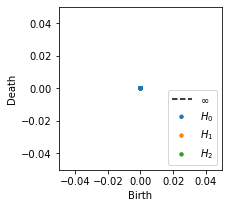

In [32]:
# Compute persistence diagrams of the pca vesion of the sliding window point cloud
res = ripser(dist_matrix1, dist maxdim=2, n_perm =300, coeff =13, thresh = 0.9)
dgms = res['dgms']
plt.figure(figsize = (3,3)) 
plot_diagrams(dgms)


In [ ]:
#Applying Dreimac 

#topological data analysis
from dreimac import CircularCoords 
from persim import plot_diagrams
from dreimac import CircleMapUtils as CMU


In [ ]:
n_lands = 200

cc = CircularCoords(XS, n_landmarks=n_lands)

plot_diagrams(cc.dgms_)

In [ ]:
# Get the circular coordinates at birth, and for the 3 cocycles with highest persistence
coho_classes = [0, 1, 2]

circular_coords = []

for i in coho_classes:
    #perc: specifies the time in filtration to construct the coordinates 
    #cocyle_index: Picks a persistent homology class when the classes are ordered with respect to persistence
    theta = cc.get_coordinates(perc= 0, cocycle_idx=i, standard_range=False)
    theta = CMU.to_sinebow(np.pi + CMU.center(theta))
    circular_coords.append(theta)

#Overall, this code snippet retrieves the circular coordinates associated with the specified cohomology classes and performs 
#some transformation on them.

In [ ]:
# Plot data with 2 circular coordinates

fig = make_subplots(rows=1, cols=len(coho_classes), 
                    subplot_titles = tuple('Circ Coord '+str(i+1) for i in coho_classes),
                    specs = [[{'type': 'scatter3d'} for i in coho_classes]])

for i, coord in enumerate(circular_coords):
    fig.add_trace(
        go.Scatter3d(x=XS_pca[:,0], y=XS_pca[:,1], z=XS_pca[:,2],   mode ='markers', 
        marker=dict(size = 2 , color =  circular_coords[i])),  
        row=1, col=i+1)
    fig.update_scenes(xaxis=dict( ticks='', showticklabels=False), 
                      yaxis=dict( ticks='', showticklabels=False), 
                      zaxis=dict( ticks='', showticklabels=False), 
                      aspectmode='data', row=1, col=i+1)

fig.update_layout( showlegend=False )
fig.show()